In [1]:
import torch
import torchvision
from torch import nn
from torch.utils import data
from d2l import torch as d2l


class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True,
                 bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=bias)
        self.bn = (
            nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True)
            if bn
            else None
        )
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat(
            (torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1
        )


class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(
            2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False
        )

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid_(x_out)
        return x * scale


class TripletAttention(nn.Module):
    def __init__(
            self,
            gate_channels,
            reduction_ratio=16,
            pool_types=["avg", "max"],
            no_spatial=False,
    ):
        super(TripletAttention, self).__init__()
        self.ChannelGateH = SpatialGate()
        self.ChannelGateW = SpatialGate()
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_perm1 = x.permute(0, 2, 1, 3).contiguous()
        x_out1 = self.ChannelGateH(x_perm1)
        x_out11 = x_out1.permute(0, 2, 1, 3).contiguous()
        x_perm2 = x.permute(0, 3, 2, 1).contiguous()
        x_out2 = self.ChannelGateW(x_perm2)
        x_out21 = x_out2.permute(0, 3, 2, 1).contiguous()
        if not self.no_spatial:
            x_out = self.SpatialGate(x)
            x_out = (1 / 3) * (x_out + x_out11 + x_out21)
        else:
            x_out = (1 / 2) * (x_out11 + x_out21)
        return x_out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

        self.triplet_attention = TripletAttention(out_channels, 16)

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.triplet_attention(self.residual_function(x)) + self.shortcut(x))


class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
        self.triplet_attention = TripletAttention(out_channels, 16)

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.triplet_attention(self.residual_function(x)) + self.shortcut(x))


class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output


def resnet18_ta():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def resnet34_ta():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def resnet50_ta():
    return ResNet(BottleNeck, [3, 4, 6, 3])


def resnet101_ta():
    return ResNet(BottleNeck, [3, 4, 23, 3])


def resnet152_ta():
    return ResNet(BottleNeck, [3, 8, 36, 3])


In [2]:
def load_data_cifar100(batch_size=128):
    transform_train = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Resize(40),
        torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                 ratio=(1.0, 1.0)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                         [0.2023, 0.1994, 0.2010])])

    transform_test = torchvision.transforms.Compose([
        #torchvision.transforms.Resize(256),
        #torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                         [0.2023, 0.1994, 0.2010])])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                             download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=0)

    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=0)
    return trainloader, testloader


def train_batch(net, X, y, loss, trainer, devices):
    X = X.to(devices)
    y = y.to(devices)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period,
          lr_decay, use_sl=True, device=d2l.try_gpu()):
    if use_sl:
        scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = net.to(device)
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss,
                                 trainer, device)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = evaluate_accuracy(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        if use_sl:
            scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
                     f' examples/sec')


def evaluate_accuracy(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]


def train_fine_tuning(net, learning_rate, lr_period, lr_decay, train_iter, valid_iter, loss, num_epochs=5,
                      param_group=True):
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period,
          lr_decay)


train loss 0.006, train acc 0.998, valid acc 0.680
155.1 examples/sec


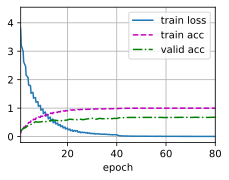

In [3]:
net = resnet50_ta()
devices = d2l.try_gpu()
num_epochs = 80
lr = 2e-4
wd = 5e-4
lr_period = 40
lr_decay = 0.1
trainloader, validloader = load_data_cifar100()
loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
train(net, trainloader, validloader, num_epochs, loss, trainer, lr_period, lr_decay)
torch.save(net.state_dict(), "triplet_att.pth", _use_new_zipfile_serialization=True)